## UHF Coefficient Matrix Trials
RHF and UHF self-consistent methods require an initial guess of the coeeficient matrix (transforms basis orbitals to molecular orbitals).
This first cell demonstrates how to calculate RHF and UHF coefficient matrices for H$_2$ and prints them.

In [42]:
import numpy as np
from pyscf import gto, scf, fci

# Create a stretched/dissociated hydrogen molecule
bond_length = 5
mol = gto.Mole()
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3  # print the converged energy and spin information
mol.build()

# Restricted Hartree-Fock (RHF)
# Number of alpha and beta spins in each orbital are equal
mf_rhf = scf.RHF(mol)  # create meanfield object
energy = mf_rhf.kernel()  # run RHF

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.kernel()  # run UHF

# Print the coefficient matrices for RHF & UHF
# The matrices are properties of the meanfield objects
rhf_c = mf_rhf.mo_coeff
print("\nRHF coefficient matrix:")
print(rhf_c)

# UHF has separate matrices for the alpha and beta spins
uhf_ca, uhf_cb = mf_uhf.mo_coeff
print("\nUHF coefficient matrices:")
print("\u03b1")  # unicode alpha
print(uhf_ca)
print("\u03b2")  # unicode beta
print(uhf_cb)

converged SCF energy = -0.599024871506153
converged SCF energy = -0.599024871506153  <S^2> = -4.4408921e-16  2S+1 = 1

RHF coefficient matrix:
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]

UHF coefficient matrices:
α
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]
β
[[ 0.70706866 -0.70714491]
 [ 0.70706866  0.70714491]]


# Difference between coefficient matrices

There is only one matrix for RHF as it is the same for $\alpha$ and $\beta$ spins.
There are two matrices for UHF for the $\alpha$ and $\beta$ spins.
However, currently both are the same, and the same as for RHF.
Let's investigate whether this is true over all bond lengths.
We can use the Frobenius norm to quantify the difference between the matrices.

The Frobenius norm of a matrix $A \in \mathbb{R}^{m \times n}$ is defined as:

$$
\|A\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}
$$

For two matrices $A$ and $B$, the Frobenius norm of their difference is:

$$
\|A - B\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n (a_{ij} - b_{ij})^2}
$$


In [2]:
# Two equivalent implementations of the Frobenius norm
print(np.linalg.norm(rhf_c - uhf_ca, 'fro'))
print(np.sqrt(np.sum((rhf_c - uhf_ca)**2)))

2.3225310689690068e-12
2.3225310689690068e-12


In [25]:
import numpy as np
from pyscf import gto, scf, fci

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(0.1, 5, 0.1)

rhf_energies = []
uhf_energies = []

rhf_coeffs = []
uhf_coeffs_a = []
uhf_coeffs_b = []

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel()  # run RHF

    # Unrestricted Hartree-Fock (UHF)
    # Number of alpha and beta spins in each orbital can differ
    mf_uhf = scf.UHF(mol)  # create meanfield object
    uhf_energy = mf_uhf.kernel()  # run UHF

    rhf_energies.append(rhf_energy)
    uhf_energies.append(uhf_energy)

    rhf_coeffs.append(mf_rhf.mo_coeff)
    uhf_coeffs_a.append(mf_uhf.mo_coeff[0])
    uhf_coeffs_b.append(mf_uhf.mo_coeff[1])


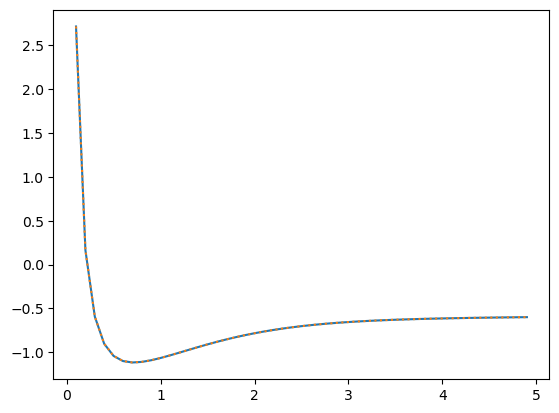

In [30]:
from matplotlib import pyplot as plt
uhf_energies = np.array(uhf_energies)
rhf_energies = np.array(rhf_energies)
plt.plot(bond_lengths, uhf_energies)
plt.plot(bond_lengths, rhf_energies, ':')

In [31]:
# Make numpy arras for linear algebra functionality
rhf_coeffs = np.array(rhf_coeffs)
uhf_coeffs_a = np.array(uhf_coeffs_a)
uhf_coeffs_b = np.array(uhf_coeffs_b)

diff = uhf_coeffs_a - rhf_coeffs
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_a = np.sqrt(sum_sq)

diff = uhf_coeffs_b - rhf_coeffs
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_b = np.sqrt(sum_sq)

diff = uhf_coeffs_b - uhf_coeffs_a
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_ab = np.sqrt(sum_sq)

Text(0, 0.5, 'Frobenius norm')

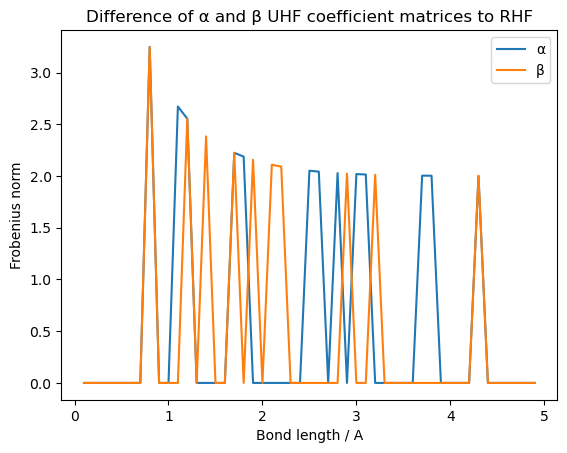

In [6]:
from matplotlib import pyplot as plt
plt.plot(bond_lengths, norms_a, label='\u03b1')  # unicode alpha
plt.plot(bond_lengths, norms_b, label='\u03b2')  # unicode beta
plt.legend()
plt.title("Difference of \u03b1 and \u03b2 UHF coefficient matrices to RHF")
plt.xlabel("Bond length / A")
plt.ylabel("Frobenius norm")

# Mixing UHF coeff matrix
Here we take the RHF coefficient matrix, apply a unitary rotation, then set this as the starting point for UHF.
First build the rotation matrix by exponentiation, giving an anticlockwise rotation by the specified angle.
The transpose rotates in the clockwise direction.

In [48]:
import numpy as np
from scipy.linalg import expm

angle = 0.25 * np.pi
q = expm([[0, -angle], [angle, 0]])

print("Q")
print(q)
print("Q transpose")
print(q.T)

# matrix = np.array([[2, 0], [0, 1]])
# print("Q M")
# print(q @ matrix)
# print("M Q")
# print(matrix @ q)
#
# print("Q' M")
# print(q.T @ matrix)
# print("M Q'")
# print(matrix @ q.T)

Q
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Q transpose
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [66]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

# Create a stretched/dissociated hydrogen molecule
bond_length = 3
mol = gto.Mole()
mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
mol.charge = 0
mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
mol.verbose = 3  # print the converged energy and spin information
mol.build()

# Use RHF soln as the starting point for UHF
mf_rhf = scf.RHF(mol)
rhf_energy = mf_rhf.kernel()
ca = cb = mf_rhf.mo_coeff
print("\nRHF coefficient matrix:")
print(mf_rhf.mo_coeff)

# Rotate the coeff matrix
angle = 0.1 * np.pi
q = expm(np.array([[0, -angle], [angle, 0]]))  # a rotation matrix
ca = ca @ q  # rotation q is rotating basis before coefficient matrix is applied
cb = cb @ q.T  # rotate in opposite direction
print("\nUFH coefficient matrix \u03b1:")
print(ca)
print("\nUFH coefficient matrix \u03b2:")
print(cb)
print('\n')

# Unrestricted Hartree-Fock (UHF)
# Number of alpha and beta spins in each orbital can differ
mf_uhf = scf.UHF(mol)  # create meanfield object
mf_uhf.mo_coeff = [ca, cb]  # set rotated coeff matrices
uhf_energy = mf_uhf.kernel()  # run UHF

ca, cb = mf_uhf.mo_coeff
print("\nUFH coefficient matrix \u03b1:")
print(ca)
print("\nUFH coefficient matrix \u03b2:")
print(cb)
print('\n')

cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
fci_energy = cisolver.kernel()[0]

print("RHF:", rhf_energy)
print("UHF:", uhf_energy)
print("FCI:", fci_energy)

converged SCF energy = -0.656048251145591

RHF coefficient matrix:
[[ 0.70073708 -0.71365341]
 [ 0.70073708  0.71365341]]

UFH coefficient matrix α:
[[ 0.44590953 -0.89526439]
 [ 0.88697159  0.46218506]]

UFH coefficient matrix β:
[[ 0.88697159 -0.46218506]
 [ 0.44590953  0.89526439]]


converged SCF energy = -0.656048251145591  <S^2> = -4.4408921e-16  2S+1 = 1

UFH coefficient matrix α:
[[ 0.70073708  0.71365341]
 [ 0.70073708 -0.71365341]]

UFH coefficient matrix β:
[[ 0.70073708  0.71365341]
 [ 0.70073708 -0.71365341]]


RHF: -0.656048251145591
UHF: -0.6560482511455912
FCI: -0.9336318445584986


In [102]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

fci_energies: list[float] = []
rhf_energies: list[float] = []
uhf_energies: list[float] = []

# Create hydrogen molecule over changing bond lengths
bond_lengths = np.arange(5, 5.5, 0.1)
angles = np.array([0, 0.1, 0.25, 0.5]) * np.pi

for bond_length in bond_lengths:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"  # in Angstrom by default
    mol.basis = "STO-3G"  # minimal basis, 1s from each H atom, two molecular orbitals
    mol.charge = 0
    mol.spin = 0  # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0  # no printing, too many bond lengths
    mol.build()

    # Restricted Hartree-Fock (RHF)
    # Number of alpha and beta spins in each orbital are equal
    mf_rhf = scf.RHF(mol)  # create meanfield object
    rhf_energy = mf_rhf.kernel()  # run RHF
    rhf_energies.append(rhf_energy)  # save RHF energy

    # for angle in angles:
    #     # Rotation matrix
    #     q = expm(np.array([[0, -angle], [angle, 0]]))
    #
    #     # Rotate coeff matrices
    #     ca = cb = mf_rhf.mo_coeff
    #     ca = ca @ q
    #     cb = cb @ q.T  # why the transpose here?
    #
    #     mf_uhf = scf.UHF(mol)  # create meanfield object
    #     mf_uhf.mo_coeff = [ca, cb]  # set initial coeffs
    #
    #     # Run UHF and save data
    #     uhf_energy = mf_uhf.kernel()
    #     uhf_energies.append(uhf_energy)
    #
    # chunk = len(angles)
    # uhf_energies = [uhf_energies[i:i+chunk] for i in range(0, len(uhf_energies), chunk)]
    # uhf_energies = list(zip(*uhf_energies))

    # Rotation matrix
    angle = 0.25 * np.pi
    q = expm(np.array([[0, -angle], [angle, 0]]))

    # Rotate coeff matrices
    ca = cb = mf_rhf.mo_coeff
    ca = ca @ q
    cb = cb @ q.T

    mf_uhf = scf.UHF(mol)  # create meanfield object
    mf_uhf.mo_coeff = [ca, cb]  # set initial coeffs
    uhf_energy = mf_uhf.kernel()  # run UHF
    uhf_energies.append(uhf_energy)  # save energy

    # FCI energy
    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)


In [105]:
mf_rhf.stability()

(array([[ 0.70709603, -0.70711753],
        [ 0.70709603,  0.70711753]]),
 None)

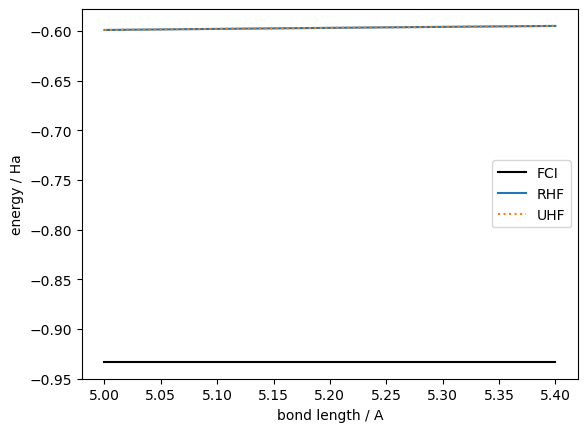

In [103]:
plt.plot(bond_lengths, fci_energies, 'k', label="FCI")
plt.plot(bond_lengths, rhf_energies, label="RHF")

# for i, angle in enumerate(angles):
#     plt.plot(bond_lengths, uhf_energies1[i], label=f"UHF {angle:.2f}")
plt.plot(bond_lengths, uhf_energies, ':', label="UHF")

plt.xlabel("bond length / A")
plt.ylabel("energy / Ha")
plt.legend()

Text(0, 0.5, 'Frobenius norm')

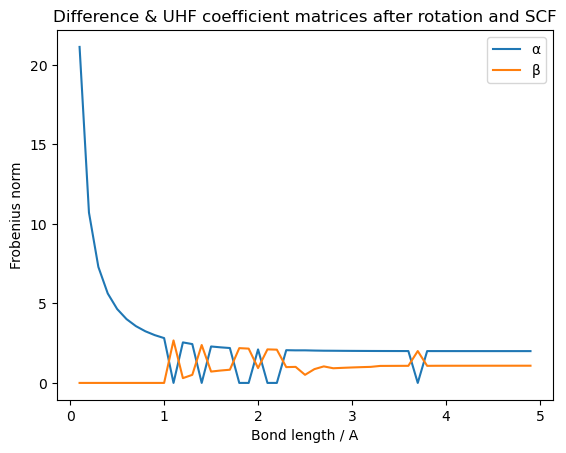

In [23]:
from matplotlib import pyplot as plt

# Make numpy arras for linear algebra functionality
uhf_coeffs_a0 = np.array(uhf_coeffs_a0)
uhf_coeffs_b0 = np.array(uhf_coeffs_b0)
uhf_coeffs_a1 = np.array(uhf_coeffs_a1)
uhf_coeffs_b1 = np.array(uhf_coeffs_b1)

diff = uhf_coeffs_a1 - uhf_coeffs_a0
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_a = np.sqrt(sum_sq)

diff = uhf_coeffs_b1 - uhf_coeffs_b0
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_b = np.sqrt(sum_sq)

plt.plot(bond_lengths, norms_a, label='\u03b1')  # unicode alpha
plt.plot(bond_lengths, norms_b, label='\u03b2')  # unicode beta
plt.legend()
plt.title("Difference & UHF coefficient matrices after rotation and SCF")
plt.xlabel("Bond length / A")
plt.ylabel("Frobenius norm")

Text(0, 0.5, 'Frobenius norm')

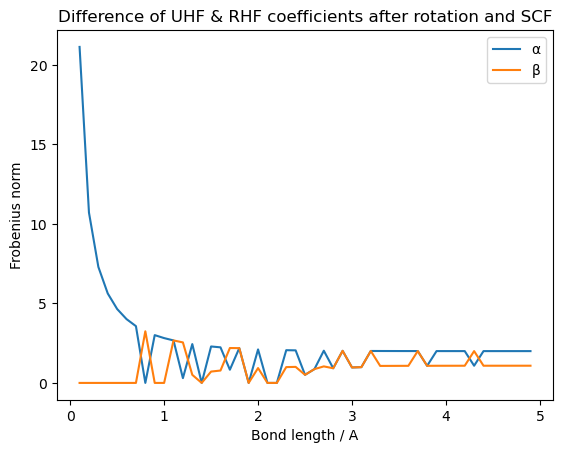

In [24]:
from matplotlib import pyplot as plt

# Make numpy arras for linear algebra functionality
rhf_coeffs = np.array(rhf_coeffs)
uhf_coeffs_a1 = np.array(uhf_coeffs_a1)
uhf_coeffs_b1 = np.array(uhf_coeffs_b1)

diff = uhf_coeffs_a1 - rhf_coeffs
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_a = np.sqrt(sum_sq)

diff = uhf_coeffs_b1 - rhf_coeffs
squared = np.square(diff)
sum_sq = squared.sum(axis=(1, 2))
norms_b = np.sqrt(sum_sq)

plt.plot(bond_lengths, norms_a, label='\u03b1')  # unicode alpha
plt.plot(bond_lengths, norms_b, label='\u03b2')  # unicode beta
plt.legend()
plt.title("Difference of UHF & RHF coefficients after rotation and SCF")
plt.xlabel("Bond length / A")
plt.ylabel("Frobenius norm")

# Potential energy curves RHF vs UHF

In [40]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
uhf_energies = np.array(uhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

rhf_err = rhf_energies - fci_energies
uhf_err = uhf_energies - fci_energies
mix_err = mixed_energies - fci_energies

plt.plot(bond_lengths, rhf_err, label="RHF")
plt.plot(bond_lengths, mix_err, ':', label="UHF")
plt.legend()
plt.xlabel("Bond length / A")
plt.ylabel("Energy error / Ha")
plt.show()

ValueError: operands could not be broadcast together with shapes (660,) (0,) 

# Rotate UHF coefficient matrix
Looking at dissociation limit, bond length of 6A.

In [25]:
import numpy as np
from scipy.linalg import expm
from pyscf import gto, scf, fci

rhf_energies = []
uhf_energies = []
uhf_energies_mixed = []
fci_energies = []

angles = np.arange(0, 2, 0.05)

for angle in angles:
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 6"    # in Angstrom by default
    mol.basis = "STO-3G"
    mol.charge = 0
    mol.spin = 0   # number of unpaired electrons: 0 => singlet (default)
    mol.verbose = 0
    mol.build()

    mf_rhf = scf.RHF(mol)
    rhf_energies.append(mf_rhf.kernel())

    mf_uhf = scf.UHF(mol)
    uhf_energies.append(mf_uhf.kernel())

    ca = mf_uhf.mo_coeff[0]
    cb = mf_uhf.mo_coeff[1]
    # print(ca)
    # print(cb)

    q = expm(np.array([[0, -angle], [angle, 0]]))
    ca = ca @ q
    cb = cb @ q.T
    # print(ca)
    # print(cb)

    mf_uhf.mo_coeff = [ca, cb]
    mf_uhf.verbose = 3
    uhf_energies_mixed.append(mf_uhf.kernel())
    # print(mf_uhf.mo_coeff)

    cisolver = fci.FCI(mol, mf_rhf.mo_coeff)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)


converged SCF energy = -0.589971420712877  <S^2> = -8.8817842e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.421012281990881 after 50 cycles  <S^2> = 2.5845992e-13  2S+1 = 1
SCF not converged.
SCF energy = -0.586969069388028 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.246754001417519 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
SCF not converged.
SCF energy = -0.470042221194235 after 50 cycles  <S^2> = 1.4876989e-14  2S+1 = 1
SCF not converged.
SCF energy = -0.24681665397546 after 50 cycles  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.246753957265093  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957372626  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957434972  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957471169  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -0.246753957492249  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.246753957504378 

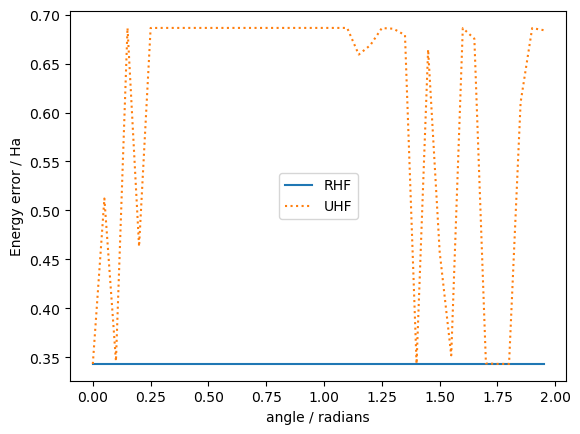

In [26]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
uhf_energies = np.array(uhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

rhf_err = rhf_energies - fci_energies
uhf_err = uhf_energies - fci_energies
mix_err = mixed_energies - fci_energies

plt.plot(angles, rhf_err, label="RHF")
plt.plot(angles, mix_err, ':', label="UHF")
plt.legend()
plt.xlabel("angle / radians")
plt.ylabel("Energy error / Ha")
plt.show()

In [38]:
import numpy as np
from pyscf import gto, scf
from scipy.linalg import expm
from time import time

# Empty lists to store results
rhf_energies = []
uhf_energies_mixed = []
fci_energies = []

# UHF mixing angle and hydrogen bond lengths to iterate over
angles = np.linspace(0, 0.5, 11) * np.pi
bond_lengths = np.linspace(0.1, 6, 60)

# Create a mesh of each unique x, y pair
# The x-axis is mixing angle, the y-axis is bond length
X, Y = np.meshgrid(bond_lengths, angles)

# Calculate RHF and mixed UHF scanning over angles and bond lengths
for bond_length, angle in zip(X.ravel(), Y.ravel()):
    print(f"angle, length: {angle:.2f}, {bond_length:.2f}")
    mol = gto.Mole()
    mol.atom = f"H 0 0 0; H 0 0 {bond_length}"    # in Angstrom by default
    mol.basis = "STO-3G"
    mol.charge = 0
    mol.spin = 0   # number of unpaired electrons: 0 is singlet (default)
    # mol.verbose = 0
    mol.build()

    # Run restricted Hartree-Fock and store the energy
    mf_rhf = scf.RHF(mol)
    mf_rhf.verbose = 0
    rhf_energies.append(mf_rhf.kernel())

    # Run the unrestricted Hartree-Fock object
    mf_uhf = scf.UHF(mol)
    mf_uhf.verbose = 0
    mf_uhf.kernel()

    # Collect alpha/beta spins molecular orbital coeff matrices
    ca = mf_rhf.mo_coeff
    cb = mf_rhf.mo_coeff

    # Create rotation matrix and rotate coeff matrices
    q = expm(np.array([[0, -angle], [angle, 0]]))
    ca = ca @ q
    cb = cb @ q.T

    mf_uhf.mo_coeff = [ca, cb]
    mf_uhf.verbose = 0
    uhf_energies_mixed.append(mf_uhf.kernel())

# import pickle
# with open(f"data_{round(time())}.pkl", "wb") as f:
#     pickle.dump((fci_energies, rhf_energies, mixed_energies), f)

angle, length: 0.00, 0.10
angle, length: 0.00, 0.20
angle, length: 0.00, 0.30
angle, length: 0.00, 0.40
angle, length: 0.00, 0.50
angle, length: 0.00, 0.60
angle, length: 0.00, 0.70
angle, length: 0.00, 0.80
angle, length: 0.00, 0.90
angle, length: 0.00, 1.00
angle, length: 0.00, 1.10
angle, length: 0.00, 1.20
angle, length: 0.00, 1.30
angle, length: 0.00, 1.40
angle, length: 0.00, 1.50
angle, length: 0.00, 1.60
angle, length: 0.00, 1.70
angle, length: 0.00, 1.80
angle, length: 0.00, 1.90
angle, length: 0.00, 2.00
angle, length: 0.00, 2.10
angle, length: 0.00, 2.20
angle, length: 0.00, 2.30
angle, length: 0.00, 2.40
angle, length: 0.00, 2.50
angle, length: 0.00, 2.60
angle, length: 0.00, 2.70
angle, length: 0.00, 2.80
angle, length: 0.00, 2.90
angle, length: 0.00, 3.00
angle, length: 0.00, 3.10
angle, length: 0.00, 3.20
angle, length: 0.00, 3.30
angle, length: 0.00, 3.40
angle, length: 0.00, 3.50
angle, length: 0.00, 3.60
angle, length: 0.00, 3.70
angle, length: 0.00, 3.80
angle, lengt

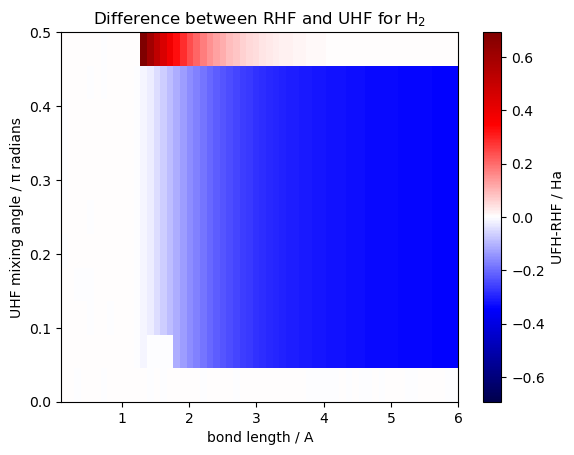

In [39]:
from matplotlib import pyplot as plt

rhf_energies = np.array(rhf_energies)
mixed_energies = np.array(uhf_energies_mixed)
fci_energies = np.array(fci_energies)

uhf_rhf_diff = mixed_energies - rhf_energies
uhf_rhf_diff = uhf_rhf_diff.reshape(X.shape)

angles_per_pi = angles / np.pi

# Plot heatmap of difference between RHF and UHF
plt.imshow(
    uhf_rhf_diff,
    extent=[bond_lengths.min(), bond_lengths.max(), angles_per_pi.min(), angles_per_pi.max()],
    origin='lower',
    cmap='seismic',
    vmin=-np.max(abs(uhf_rhf_diff)),  # force symmetric colour scale which gives
    vmax= np.max(abs(uhf_rhf_diff)),  # different colours for positive and negative values
    aspect='auto',
)

plt.colorbar(label="UFH-RHF / Ha")
plt.xlabel("bond length / A")
plt.ylabel("UHF mixing angle / π radians")
plt.title("Difference between RHF and UHF for H$_2$")
plt.show()